# Advanced modelling and feature engineering of Music Recommendation System

**Submitted By:** Debojyoti Choudhury

**Enrollment Number:** 40AIML137-21/2

**Programme:** Diploma in AI and ML

The purpose of this notebook is to take the preprocessed (model-ready) data and build advanced models using it.

## Importing necessary libraries

In [1]:
import numpy as np                                                    # for fast processing of tabular data
import pandas as pd                                                   # data processing, CSV file I/O
import matplotlib.pyplot as plt                                       # for data visualization
import seaborn as sns                                                 # for data visualization
from sklearn.ensemble import RandomForestClassifier                   # for random forest classifier
import xgboost                                                        # for extreme gradient boosting
import lightgbm                                                       # for light gradient boosting machine
from sklearn.model_selection import RandomizedSearchCV                # for randomised-search based hyper parameter tuning
from sklearn.metrics import roc_auc_score, accuracy_score             # metrics to identify classifier performance
from sklearn.metrics import classification_report                     # to produce classsifier report
from sklearn.metrics import roc_curve, plot_roc_curve, auc            # for plotting roc curve
from sklearn.metrics import plot_confusion_matrix                     # for plotting confusion matrix
import time                                                           # to keep track of time the algorithm takes

## Read the sample dataset

As the system configuration is not enough to handle all the data we will use sampled dataset to train our models.

In [2]:
train_data = pd.read_csv("../Data/sampled_data/sampled_train_data.csv.gz", compression='gzip',index_col=False)
validation_data = pd.read_csv("../Data/sampled_data/sampled_validation_data.csv.gz", compression='gzip', index_col=False)

In [3]:
train_data.shape, validation_data.shape

((1180387, 43), (295097, 43))

## Selecting X_tr, y_tr, X_val, y_val

In [4]:
features = train_data.drop(['Unnamed: 0','song_id', 'target'], axis=1).columns
features

Index(['msno', 'source_system_tab', 'source_screen_name', 'source_type',
       'city', 'bd', 'gender', 'registered_via', 'registration_year',
       'registration_month', 'registration_day', 'expiration_year',
       'expiration_month', 'expiration_day', 'membership_days', 'song_length',
       'first_genre_id', 'second_genre_id', 'third_genre_id',
       'genre_ids_count', 'artist_name', 'language', 'is_featured',
       'artist_count', 'first_artist_name', 'lyricist_count', 'first_lyricist',
       'composer_count', 'first_composer', 'country_code', 'registration_code',
       'song_year', 'member_song_count', 'artist_song_count',
       'composer_song_count', 'lyricist_song_count', 'genre_song_count',
       'lang_song_count', 'song_member_count', 'age_song_count'],
      dtype='object')

In [5]:
X_tr = train_data.drop(['Unnamed: 0', 'song_id', 'target'], axis=1)
y_tr = train_data['target']

X_val = validation_data.drop(['Unnamed: 0','song_id', 'target'], axis=1)
y_val = validation_data['target']

In [6]:
X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((1180387, 40), (1180387,), (295097, 40), (295097,))

## Random Forest Classifier

### Fitting Random Forest Classifier Model

In [25]:
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, min_samples_split=10, max_depth=25)

In [26]:
rf_clf.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=200,
                       n_jobs=-1)

### Generating the classification reports

In [20]:
def class_report(estimator):
    estimator_name = estimator.__class__.__name__
    print("Classification Report of ", estimator_name," on training dataset\n")
    y_p = estimator.predict(X_tr)
    print(classification_report(y_true = y_tr, y_pred = y_p))
    print("\n")
    print("Classification Report of ", estimator_name," on validation dataset\n")
    y_p = estimator.predict(X_val)
    print(classification_report(y_true = y_val, y_pred = y_p))

In [27]:
class_report(rf_clf)

Classification Report of  RandomForestClassifier  on training dataset

              precision    recall  f1-score   support

           0       0.90      0.80      0.85    586166
           1       0.82      0.91      0.87    594221

    accuracy                           0.86   1180387
   macro avg       0.86      0.86      0.86   1180387
weighted avg       0.86      0.86      0.86   1180387



Classification Report of  RandomForestClassifier  on validation dataset

              precision    recall  f1-score   support

           0       0.70      0.64      0.67    146548
           1       0.67      0.73      0.70    148549

    accuracy                           0.68    295097
   macro avg       0.68      0.68      0.68    295097
weighted avg       0.68      0.68      0.68    295097



### ROC-AUC

In [28]:
def plot_roc(estimator):
    estimator_name = estimator.__class__.__name__
    
    y_p = estimator.predict_proba(X_tr)[:,1]
    fprt, tprt, _ = roc_curve(y_true=y_tr, y_score=y_p)
    roc_auc_tr = auc(fprt, tprt)
    
    y_p = estimator.predict_proba(X_val)[:,1]
    fprv, tprv, _ = roc_curve(y_true=y_val, y_score=y_p)
    roc_auc_val = auc(fprv, tprv)
    
    plt.figure(figsize=(10,8))
    lw = 1.5
    plt.plot(
        fprt,
        tprt,
        color="green",
        lw=lw,
        label="ROC curve (area = %0.2f) on training dataset" % roc_auc_tr,
    )
    plt.plot(
        fprv,
        tprv,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f) on validation dataset" % roc_auc_val,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"Receiver operating characteristic of {estimator_name} model", fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

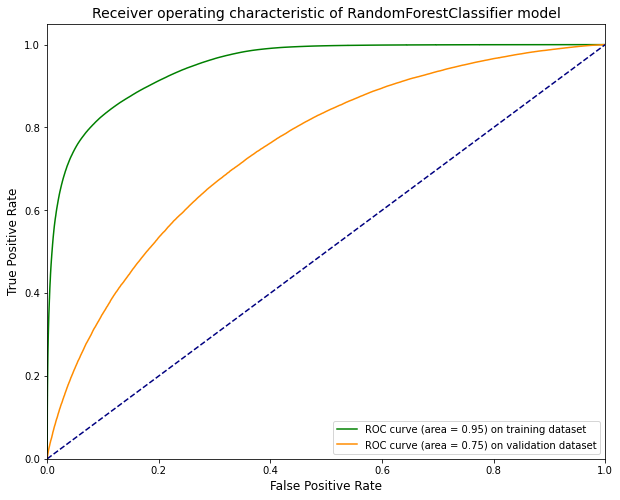

In [29]:
plot_roc(rf_clf)

### Error analysis : Confusion Matrix on validation dataset

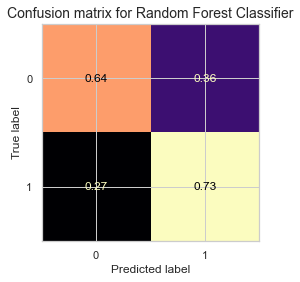

In [44]:
plot_confusion_matrix(rf_clf, X_val, y_val, normalize = 'true', colorbar=False, cmap='magma')
plt.title("Confusion matrix for Random Forest Classifier", fontsize=14)
plt.show()

### Feature importance

In [32]:
def plot_feature_importance(data, model):
    '''Function to plot top-20 feature imporatance'''
    plt.figure(figsize=(15,10))
    sns.set(font_scale=1.25)
    sns.set(style="whitegrid")
    plt.xlabel('features',fontsize=14)
    plt.ylabel('importance',fontsize=14)
    plt.xticks(rotation='90')
    ax = sns.barplot(x='features', y='importance', data=data)
    plt.title('Top 20 features ranked by importance for {model}'.format(model=model),fontsize=16)
    plt.tight_layout()

In [33]:
# create dataframe for features and it importance

sorted_indices = np.abs(rf_clf.feature_importances_).argsort()[::-1][:20]
imp_features = features[sorted_indices]
rf_fea_imp = pd.DataFrame({
    'features' : imp_features,
    'importance' : np.abs(rf_clf.feature_importances_)[sorted_indices]
})

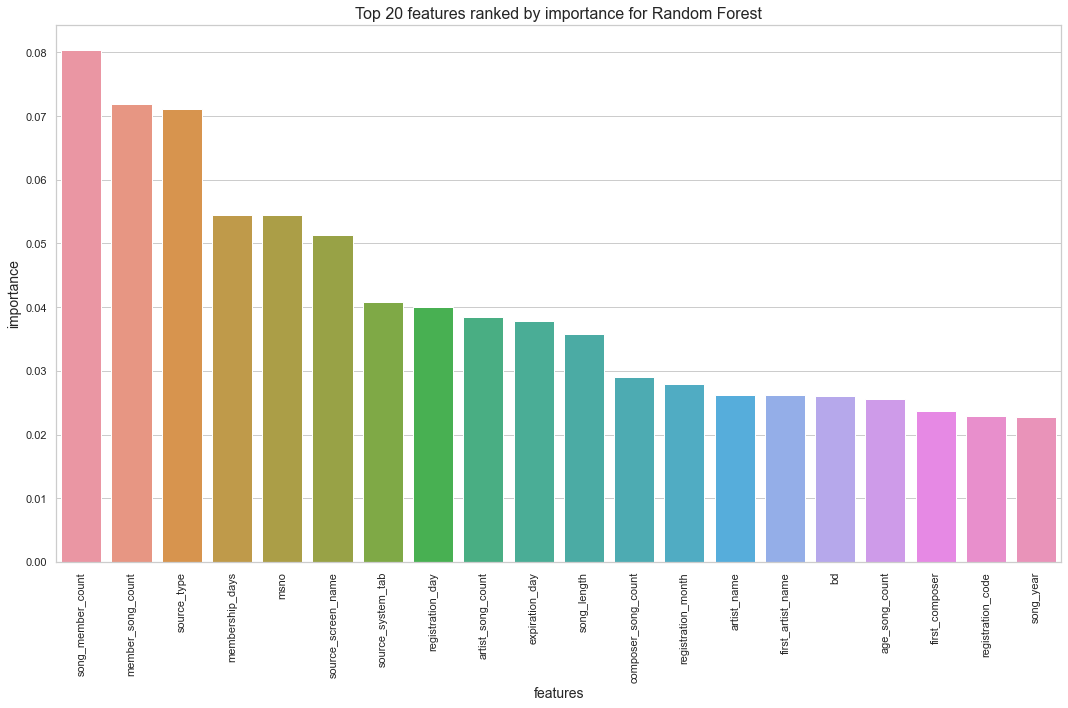

In [34]:
plot_feature_importance(data=rf_fea_imp, model='Random Forest')

## XGBoost Classifier

### Fitting XGBoost classifier

In [39]:
xgb_clf = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
                                colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
                                learning_rate=0.03, max_delta_step=0, max_depth=25,
                                min_child_weight=10, n_estimators=200, n_jobs=-1,
                                nthread=None, objective='binary:logistic', random_state=2,
                                reg_alpha=0, reg_lambda=2, )

In [40]:
xgb_clf.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=2, reg_alpha=0, ...)

### Generating classification report

In [41]:
class_report(xgb_clf)

Classification Report of  XGBClassifier  on training dataset

              precision    recall  f1-score   support

           0       0.91      0.89      0.90    586166
           1       0.89      0.91      0.90    594221

    accuracy                           0.90   1180387
   macro avg       0.90      0.90      0.90   1180387
weighted avg       0.90      0.90      0.90   1180387



Classification Report of  XGBClassifier  on validation dataset

              precision    recall  f1-score   support

           0       0.72      0.70      0.71    146548
           1       0.71      0.73      0.72    148549

    accuracy                           0.71    295097
   macro avg       0.71      0.71      0.71    295097
weighted avg       0.71      0.71      0.71    295097



### ROC-AUC

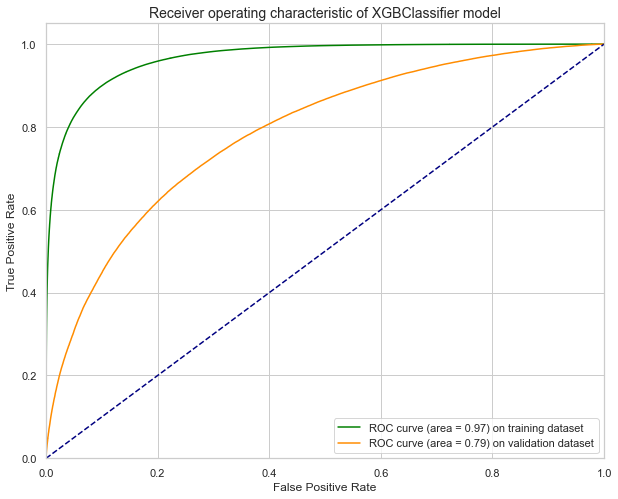

In [42]:
plot_roc(xgb_clf)

### Error analysis : Confusion Matrix on validation dataset

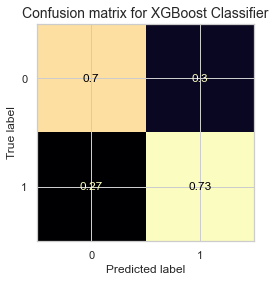

In [45]:
plot_confusion_matrix(xgb_clf, X_val, y_val, normalize = 'true', colorbar=False, cmap='magma')
plt.title("Confusion matrix for XGBoost Classifier", fontsize=14)
plt.show()

### Feature importance

In [46]:
# create dataframe for features and it importance

sorted_indices = np.abs(xgb_clf.feature_importances_).argsort()[::-1][:20]
imp_features = features[sorted_indices]
xgb_fea_imp = pd.DataFrame({
    'features' : imp_features,
    'importance' : np.abs(xgb_clf.feature_importances_)[sorted_indices]
})

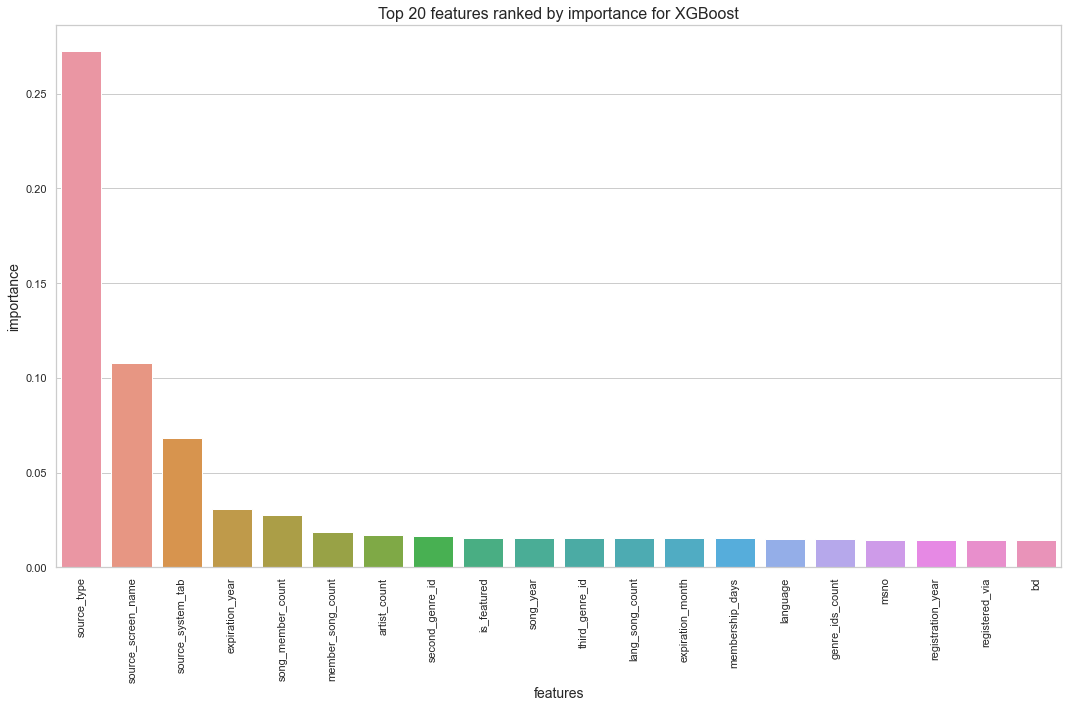

In [48]:
plot_feature_importance(data=xgb_fea_imp, model='XGBoost')

## LightGBM Classifier

### Fitting LightGBM Classifer

In [49]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.05,
        'verbose': 0,
        'num_leaves': 100,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 400,
        'metric' : 'auc'
    }

In [51]:
lgb_tr_data = lightgbm.Dataset(X_tr, y_tr)
lgb_val_data = lightgbm.Dataset(X_val, y_val)

In [52]:
lgb_clf = lightgbm.train(params, train_set=lgb_tr_data,  valid_sets=lgb_val_data, verbose_eval=20)

C:\Users\SouravKarmakar\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\SouravKarmakar\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[20]	valid_0's auc: 0.703582
[40]	valid_0's auc: 0.706931
[60]	valid_0's auc: 0.710368
[80]	valid_0's auc: 0.713894
[100]	valid_0's auc: 0.716394
[120]	valid_0's auc: 0.719422
[140]	valid_0's auc: 0.721569
[160]	valid_0's auc: 0.723351
[180]	valid_0's auc: 0.725341
[200]	valid_0's auc: 0.726691
[220]	valid_0's auc: 0.728009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's auc: 0.729169
[260]	valid_0's auc: 0.730347
[280]	valid_0's auc: 0.731211
[300]	valid_0's auc: 0.732227
[320]	valid_0's auc: 0.733294
[340]	valid_0's auc: 0.733951
[360]	valid_0's auc: 0.735071
[380]	valid_0's auc: 0.736076
[400]	valid_0's auc: 0.73718


### Generating classification report

In [59]:
print("Classification Report of LightGBM on training dataset\n")
y_prob = lgb_clf.predict(X_tr)
y_p = np.array([1 if x >= 0.5 else 0 for x in y_prob])
print(classification_report(y_true = y_tr, y_pred = y_p))

Classification Report of LightGBM on training dataset

              precision    recall  f1-score   support

           0       0.69      0.64      0.67    586166
           1       0.67      0.72      0.70    594221

    accuracy                           0.68   1180387
   macro avg       0.68      0.68      0.68   1180387
weighted avg       0.68      0.68      0.68   1180387



In [60]:
print("Classification Report of LightGBM on validation dataset\n")
y_prob = lgb_clf.predict(X_val)
y_p = np.array([1 if x >= 0.5 else 0 for x in y_prob])
print(classification_report(y_true = y_val, y_pred = y_p))

Classification Report of LightGBM on validation dataset

              precision    recall  f1-score   support

           0       0.68      0.64      0.66    146548
           1       0.66      0.71      0.69    148549

    accuracy                           0.67    295097
   macro avg       0.67      0.67      0.67    295097
weighted avg       0.67      0.67      0.67    295097



### ROC-AUC

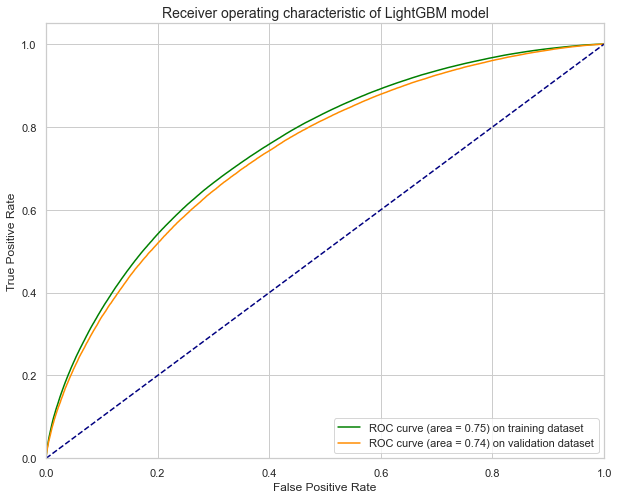

In [62]:
y_p = lgb_clf.predict(X_tr)
fprt, tprt, _ = roc_curve(y_true=y_tr, y_score=y_p)
roc_auc_tr = auc(fprt, tprt)
    
y_p = lgb_clf.predict(X_val)
fprv, tprv, _ = roc_curve(y_true=y_val, y_score=y_p)
roc_auc_val = auc(fprv, tprv)
    
plt.figure(figsize=(10,8))
lw = 1.5
plt.plot(
    fprt,
    tprt,
    color="green",
    lw=lw,
    label="ROC curve (area = %0.2f) on training dataset" % roc_auc_tr,
)
plt.plot(
    fprv,
    tprv,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f) on validation dataset" % roc_auc_val,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"Receiver operating characteristic of LightGBM model", fontsize=14)
plt.legend(loc="lower right")
plt.show()

### Error Analysis : Confusion Matrix on validation dataset

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
y_prob = lgb_clf.predict(X_val)
y_p = np.array([1 if x >= 0.5 else 0 for x in y_prob])

In [67]:
cm = confusion_matrix(y_true = y_val, y_pred = y_p)

In [68]:
cm

array([[ 93389,  53159],
       [ 43133, 105416]], dtype=int64)

In [70]:
cm / cm.sum(axis = 1)

array([[0.63725878, 0.35785498],
       [0.29432677, 0.7096379 ]])

In [71]:
cm_df = pd.DataFrame(cm / cm.sum(axis = 1), index=[0, 1], columns=[0, 1])

In [72]:
cm_df

,0,1
0,0.637259,0.357855
1,0.294327,0.709638


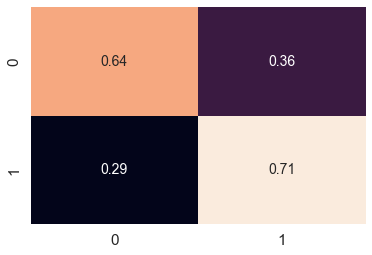

In [73]:
sns.set(font_scale=1.4)
sns.heatmap(cm_df, annot=True, annot_kws={"size": 14}, cbar=False) 
plt.show()

### Feature importance 

In [83]:
fi =lgb_clf.feature_importance()
fi = np.round(100 * fi / sum(fi), 3)
fi

array([ 9.736,  2.777,  1.759,  3.469,  2.304,  4.164,  1.094,  1.807,
        1.847,  3.543,  5.867,  1.097,  3.015,  5.612,  8.498,  1.88 ,
        1.425,  0.301,  0.04 ,  0.053,  2.35 ,  1.064,  0.023,  0.134,
        0.364,  0.25 ,  0.859,  0.371,  1.337,  0.94 ,  1.617,  2.176,
       12.632,  2.997,  1.263,  0.841,  1.471,  1.001,  4.98 ,  3.042])

In [85]:
sorted_indices = fi.argsort()[::-1][:20]
imp_features = features[sorted_indices]
lgb_fea_imp = pd.DataFrame({
    'features' : imp_features,
    'importance' : fi[sorted_indices]
})

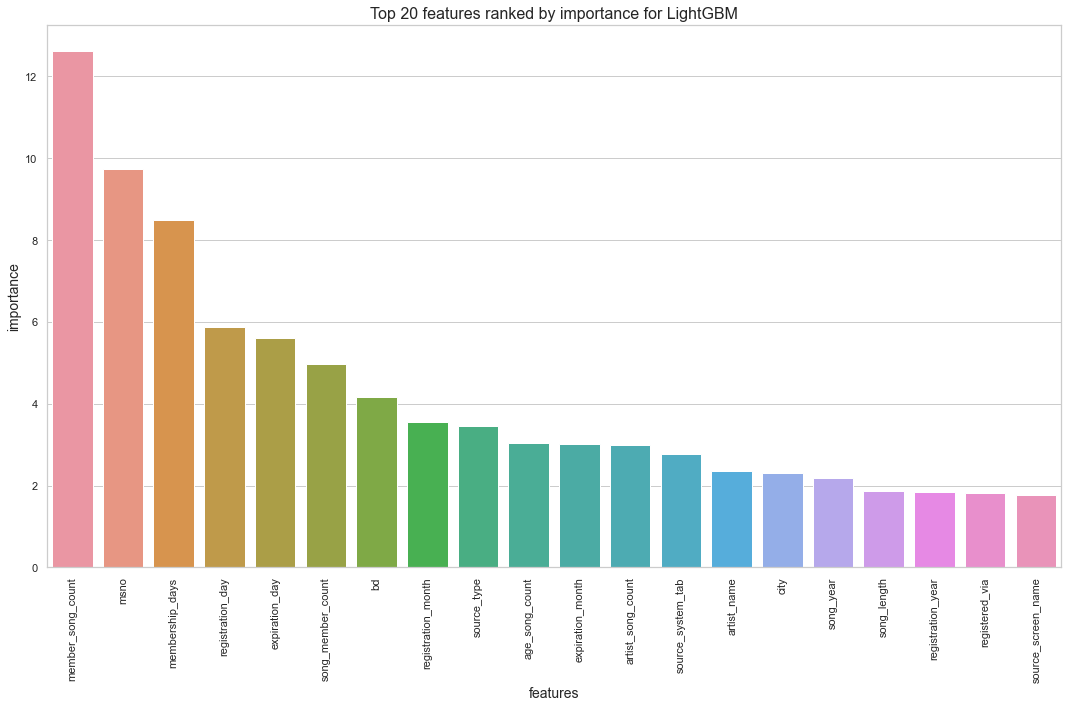

In [88]:
plot_feature_importance(data=lgb_fea_imp, model='LightGBM')